In [18]:
# ---imports---
import sys
import os
import random
sys.path.append('.')
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import lightning.pytorch as pl
import rasterio

from models.DeepLabV3_Lightning_ESRI_UrbanRural import DeepLabV3_Lightning_ESRI_UrbanRural

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import patches as mpatches

### Cross-validation fold setup

In [19]:
# No need to change
fold_1 = ['Algeria', 'Niger', 'Mauritania', 'Mozambique', 'CentralAfricanRepublic', 'Zimbabwe', 'Guinea', 'Malawi', 'Togo']
fold_2 = ['DemocraticRepublicoftheCongo', 'Angola', 'Egypt', 'Zambia', 'Madagascar', 'Congo', 'Ghana', 'Eritrea', 'Guinea-Bissau']
fold_3 = ['Sudan', 'Mali', 'UnitedRepublicofTanzania', 'Morocco', 'Botswana', 'CotedIvoire', 'Uganda', 'Benin', 'Lesotho']
fold_4 = ['Libya', 'SouthAfrica', 'Nigeria', 'SouthSudan', 'Kenya', 'BurkinaFaso', 'Senegal', 'Liberia']
fold_5 = ['Chad', 'Ethiopia', 'Namibia', 'Somalia', 'Cameroon', 'Gabon', 'Tunisia', 'SierraLeone', 'Burundi']

training_folds =  fold_1 + fold_2 + fold_3
val_fold = fold_4
test_fold = fold_5

### Codices

In [20]:
# --- Class Codices ---

# -ESRI LULC 2020 (9 classes): class codec
# 1(->0): Water
# 2(->1): Tree
# 4(->2): Flooded Vegetation
# 5(->3): Crops
# 7(->6): Built Area
# 8(->4): Bare Ground
# 9(->(-1)): Snow / Ice
# 10(->(-1)): Clouds
# 11(->5): Rangeland
# 12(->(-1)): Missing
esri_classes = [1, 2, 4, 5, 7, 8, 9, 10, 11, 12]
labels = [0, 1, 2, 3, 6, 4, -1, -1, 5, -1]

esri_class_to_index_map = np.zeros(max(esri_classes) + 1, dtype='int64')
esri_class_to_index_map[esri_classes] = labels


# ---GHS-SMOD 2020 (8 classes): class codec---
# 30(->7): URBAN CENTRE GRID CELL
# 23(->7): DENSE URBAN CLUSTER GRID CELL
# 22(->7): SEMI-DENSE URBAN CLUSTER GRID CELL
# 21(->7): SUBURBAN OR PERI-URBAN GRID CELL
# 13(->6): RURAL CLUSTER GRID CELL
# 12(->6): LOW DENSITY RURAL GRID CELL
# 11(->6): VERY LOW DENSITY RURAL GRID CELL
# 10(->6): WATER GRID CELL
# NoData [-Inf] -> 7
smod_classes = [10, 11, 12, 13, 21, 22, 23, 30]
labels = [6, 6, 6, 6, 7, 7, 7, 7]

smod_class_to_index_map = np.zeros(max(smod_classes) + 1, dtype='int64')
smod_class_to_index_map[smod_classes] = labels

### Preprocessing

In [21]:
def get_patches(images):
    '''read and preprocess images from list of image paths, return iterator'''
    
    for im_path in images:
        
        im = rasterio.open(im_path).read()
    
        # input preprocessing: normalize input bands to range (0.0, 1.0), mask missing data
        im[0:6] = (im[0:6] - 1) / (65455 - 1)  # bands SR_B2 to SR_B7: BGR, NIR, SWIR1, SWIR2 (1, 65455)
        nl_clipped = np.clip(im[6], a_min=-1.5, a_max=193565)
        im[6] = (nl_clipped + 1.5) / (193565 + 1.5)   # band avg_rad: VIIRS (-1.5, 193565), DMSP (0, 6060.6)

        inf_mask = np.isinf(im[0])
        im[0:6, inf_mask] = 0

        im[1, np.isinf(im[1])] = 0
        im[2, np.isinf(im[2])] = 0

        yield im[:7]


In [22]:
def get_patches_sub(im):
    '''split each (1000,1000)-supertile into 36*(250,250)-subtiles'''
    
    # loop through each subtile
    for sub_tile_idx in range(36):
            
        # calculate offset
        r = (sub_tile_idx // 6) * 150
        c = (sub_tile_idx % 6) * 150

        sub_tile = im[:, r:r+250, c:c+250]

        # retrieve input
        image = sub_tile[:7]

        yield (image, _)

### Load Model

In [23]:
# load model from checkpoint
mimer = "/mimer/NOBACKUP/groups/globalpoverty1/albin_and_albin/scripts_and_notebooks/job_scripts"

# model 1
ckpt = mimer + "/lightning_logs/deeplabv3_esri_urban_rural_12345/checkpoints/12345_epoch=19-step=126080-val_loss=0.440.ckpt"

# model 3
#ckpt = mimer + "/lightning_logs/deeplabv3_esri_urban_rural_34512/checkpoints/34512_epoch=19-step=106240-val_loss=0.369.ckpt"

lightning_model = DeepLabV3_Lightning_ESRI_UrbanRural.load_from_checkpoint(ckpt, training_folds=training_folds, validation_fold=fold_4).cuda()

### Load tile

In [24]:
# load tiles to predict on
year = '2021'
#im_indices = ['483', '5412', '3324', '7601', '4497', '4254', '3545', '7904', '2557']
im_indices = [2755, 1229, 1991, 1440,
              872, 1252, 3078, 2118,
              224, 2336, 1560, 2303,
              135, 2921, 2072, 1565]
#im_indices = ['311']
im_paths = [f'/mimer/NOBACKUP/groups/globalpoverty1/albin_and_albin/abidjan/input/tile_{str(im_idx)}.tif_{year}' for im_idx in im_indices]
#im_path = f'/mimer/NOBACKUP/groups/globalpoverty1/albin_and_albin/raw_data/{year}/Nigeria/tile_5412.tif_{year}'


# iterator over tiles
im_iterator = get_patches(im_paths)

# prepare target for visualization
if year == '2020':
    im = rasterio.open(im_paths[4]).read()
    smod = im[7]
    smod[np.isinf(smod)] = 10
    smod = smod.astype('int64')

    esri_labels = im[9]
    esri_labels[np.isinf(esri_labels)] = -1
    esri_labels = esri_labels.astype('int64')

    smod = smod_class_to_index_map[smod]
    esri_labels = esri_class_to_index_map[esri_labels]
    np.putmask(esri_labels, esri_labels == 6, smod)
    np.putmask(esri_labels, esri_labels == -1, 5)  # for visualizing missing data

### Inference

In [25]:
# predict on selected tile, split in its subtiles
predictions = []
subpredictions = []

for tile in im_iterator:
    
    for idx, img in enumerate(get_patches_sub(tile)):

        in_data, labels = img
        in_data = torch.tensor(in_data).cuda()
        in_data = torch.unsqueeze(in_data, 0)

        lightning_model.eval()

        with torch.no_grad():
            outputs = lightning_model(in_data)
            class_probs = F.softmax(outputs, dim=1)
            class_predictions = torch.argmax(input=class_probs, dim=1)

            subpredictions.append(class_predictions[0])

    # assemble sub-tile predictions into supertile
    predictions_supertile = np.zeros((1000, 1000))
    for sub_tile_idx in range(36):

        sub_tile = subpredictions[sub_tile_idx].squeeze()

        # calculate offset
        r = (sub_tile_idx // 6) * 150
        c = (sub_tile_idx % 6) * 150

        # adjust row margins
        if r == 0:
            row_start_margin = 0
            row_end_margin = 200
        elif r == 750:
            row_start_margin = 50
            row_end_margin = 250
        else:
            row_start_margin = 50
            row_end_margin = 200

        # adjust col margins
        if c == 0:
            col_start_margin = 0
            col_end_margin = 200
        elif c == 750:
            col_start_margin = 50
            col_end_margin = 250
        else:
            col_start_margin = 50
            col_end_margin = 200

        # put sub-tile in correct position
        cut_subtile = sub_tile[row_start_margin:row_end_margin, col_start_margin:col_end_margin]
        predictions_supertile[r+row_start_margin: r+row_end_margin, c+col_start_margin : c+col_end_margin] = cut_subtile.cpu()
    predictions.append(predictions_supertile)
    subpredictions.clear()

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

In [27]:
predictions_merged = np.zeros((4000, 4000))
for sub_tile_idx in range(16):
            
        # calculate offset
        r = (sub_tile_idx // 4) * 1000
        c = (sub_tile_idx % 4) * 1000

        predictions_merged[r:r+1000, c:c+1000] = predictions[sub_tile_idx]

### Plot

In [28]:
colormap_classes_rgb = np.array([[0, 100, 200], [0, 100, 0], [0, 207, 117], 
                                 [240, 150, 255], [180, 180, 180], [255, 187, 34], 
                                 [255, 0,0], [80,0,0]]) / 255  # RGB values for each class, normalized to (0, 1)

class_labels = ['c1:Water', 'c2:Tree', 'c3:Flooded Vegetation', 
                'c4:Crops', 'c5:Bare Ground', 'c6:Rangeland', 'c7:Rural', 'c8:Urban']

cmap_classes = ListedColormap(colormap_classes_rgb, name='ESRI_WorldCover_2020_class_cmap', N=8)

#### Prediction

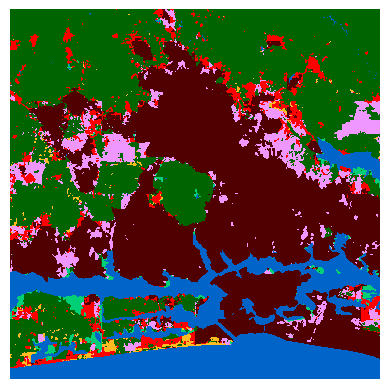

In [29]:
plt.imshow(predictions_merged, cmap=cmap_classes, vmin=0, vmax=len(colormap_classes_rgb), interpolation='nearest')
#plt.imshow(predictions[10].cpu(), cmap=cmap_classes, vmin=0, vmax=len(colormap_classes_rgb), interpolation='nearest')

plt.axis('off')
plt.savefig("mandelbrot.png") # , dpi=300, bbox_inches='tight', pad_inches=0
#plt.title('prediction')

In [30]:
plt.imsave('testing.png' , arr=predictions_merged, cmap=cmap_classes, vmin=0, vmax=len(colormap_classes_rgb))

#### Target

In [ ]:
if year == '2020':
    plt.imshow(esri_labels, cmap=cmap_classes, vmin=0, vmax=len(colormap_classes_rgb), interpolation='nearest')
    plt.axis('off')
    #plt.title('target')

#### Prediction vs Target

In [ ]:
if year == '2020':
    # plot result
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.set_title('predictions')
    ax1.imshow(predictions_supertile, cmap=cmap_classes, vmin=0, vmax=len(colormap_classes_rgb), interpolation='nearest')

    ax2.set_title('target (esri2020)')
    ax2.imshow(esri_labels, cmap=cmap_classes, vmin=0, vmax=len(colormap_classes_rgb), interpolation='nearest',)

    patches = [mpatches.Patch(color=colormap_classes_rgb[i], label=class_labels[i]) for i in range(len(class_labels))]
    ax1.axis('off')
    ax2.axis('off')
    plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.0)